In [208]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('train.csv')  

In [209]:
data = np.array(data) #turns data into an array
rows, cols = data.shape #defines the rows and columns of the array
#rows = 42000, representing the total number of images
#cols = 785, representing the number of pixels per image with an extra column of the labels

In [210]:
#seperates the label column and defines it
labels = data[:, 0]  
pixels = data[:, 1:]  

#puts the pixels representing grayscale values from a scale 0 to 255 to a 0 to 1 scale, better for gradient descent
X = pixels / 255.0

In [211]:
#coding so only one aspect of the 0 to 9 "lights" up to show accuracy
# this is why its called one hot encoding, only one can be "hot"
#basically, this makes the labels on a scale of 0 to 1 so position matters rather the magnitutude

def one_hot_encoding(y, num_classes=10):
    m = y.shape[0]  # number of examples (42000)
    Y = np.zeros((m, num_classes))  # Create matrix of zeros (42000, 10)
    Y[np.arange(m), y.astype(int)] = 1
    
    return Y

Y = one_hot_encoding(labels) 

In [212]:
X_train = X #the activations, i.e. grayscale valyes on the 0 to 1 scale 
Y_train = Y #renames and pulls form one hot econding 

def split_training_data(X_train, Y_train, val_size=0.2, random_seed=42):
    #splits training data into train and validation (test) sets
    #val size means we are taking 20% for test/validation, and training based on 80%
    m = X_train.shape[0] #total num
    val_examples = int(m * val_size) #how many for val
    print(f"Splitting: {val_examples} examples for validation, {m - val_examples} for training")

    #randomize so validation represents all numbers

    np.random.seed(random_seed)  # shuffles
    indices = np.random.permutation(m)

    # Split  into validation and training sets
    # First 'val_examples' indices go to validation, rest to training
    val_indices = indices[:val_examples]    # First 20% of shuffled indices
    train_indices = indices[val_examples:]  # Remaining 80% of shuffled indices
    
    # Use the indices to create the actual data splits
    # This is like saying: "Give me the rows at these positions"
    X_val = X_train[val_indices]  # Validation images
    Y_val = Y_train[val_indices]  # Validation labels
    
    # Update training data to exclude validation examples
    X_train = X_train[train_indices]  # Training images (smaller now)
    Y_train = Y_train[train_indices]  # Training labels (smaller now)
    
    return X_train, Y_train, X_val, Y_val  #the final groupings after splits 


X_train, Y_train, X_val, Y_val = split_training_data(X_train, Y_train)

#checking the work 
print("\nAfter splitting:")
print(f"X_train: {X_train.shape}")  # Should be (33600, 784) - 80% of 42000
print(f"Y_train: {Y_train.shape}")  # Should be (33600, 10)
print(f"X_val: {X_val.shape}")      # Should be (8400, 784)   - 20% of 42000  
print(f"Y_val: {Y_val.shape}")      # Should be (8400, 10)


Splitting: 8400 examples for validation, 33600 for training

After splitting:
X_train: (33600, 784)
Y_train: (33600, 10)
X_val: (8400, 784)
Y_val: (8400, 10)


After this point, the actual code steps are not super clear to me. And its like the actual math part

In [213]:
def initialize_parameters(layer_sizes):
    # initializing the hyperparametrs and parameters 
    parameters = {}
    L = len(layer_sizes)  # number of layers (4) --> two hidden 
    
    for l in range(1, L):
        fan_in = layer_sizes[l-1]   # neurons in previous layer
        fan_out = layer_sizes[l]    # neurons in current layer
        
        # a process of good randomization
        parameters[f'W{l}'] = np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)
        
        # initialize biases to zeros 
        parameters[f'b{l}'] = np.zeros((1, fan_out))
        
        print(f"Layer {l}: W{l}.shape = {parameters[f'W{l}'].shape}, b{l}.shape = {parameters[f'b{l}'].shape}")
    
    return parameters

# I change the layer size frequently
layer_sizes = [784, 600, 400, 10]

parameters = initialize_parameters(layer_sizes)

Layer 1: W1.shape = (784, 600), b1.shape = (1, 600)
Layer 2: W2.shape = (600, 400), b2.shape = (1, 400)
Layer 3: W3.shape = (400, 10), b3.shape = (1, 10)


In [214]:
def forward_propagation(X, parameters, layer_sizes):
    
    # store all intermediate values for backpropagation
    caches = {'A0': X}  # A0 is the input layer
    A = X  # start with input data
    
    L = len(layer_sizes) - 1  # number of weight layers 
    
    # forward pass through hidden layers 
    for l in range(1, L):  # l = 1, 2 (hidden layers)
        # linear transformation: Z = A_prev · W + b
        Z = A @ parameters[f'W{l}'] + parameters[f'b{l}']
        # ReLU activation: A = max(0, Z)
        A = relu(Z)
        
        # store for backpropagation 
        caches[f'Z{l}'] = Z
        caches[f'A{l}'] = A
        print(f"Layer {l}: Z{l}.shape = {Z.shape}, A{l}.shape = {A.shape}")
    
    # output layer (Softmax activation for probability distribution)
    Z = A @ parameters[f'W{L}'] + parameters[f'b{L}']
    A = softmax(Z)  # output probabilities
    
    caches[f'Z{L}'] = Z
    caches[f'A{L}'] = A
    print(f"Output Layer {L}: Z{L}.shape = {Z.shape}, A{L}.shape = {A.shape}")
    
    return A, caches  

# activation functions
def relu(Z):
    # ReLU activation: g(z) = max(0, z)
    return np.maximum(0, Z)

def softmax(Z):
    #Softmax activation: Softmax(z_i) = exp(z_i) / Σ_j exp(z_j)

    # Subtract max for numerical stability
    shift_Z = Z - np.max(Z, axis=1, keepdims=True)
    exp_Z = np.exp(shift_Z)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

In [215]:
def compute_cost(Y, Y_hat):
    # cross-entropy cost: J = -1/m * Σ_{i=1}^m Σ_{j=1}^k y_ij * log(ŷ_ij)
    # Where: m = number of examples; k = number of classes (10); y_ij = true label (1 if example i is class j, else 0); Y_hat_ij = predicted probability

    m = Y.shape[0]
    
    # add small epsilon to avoid log(0)
    cost = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
    
    return cost

In [216]:
# test forward propagation with a small batch
batch_size = 64
X_batch = X_train[:batch_size]
Y_batch = Y_train[:batch_size]

# perform forward pass
Y_hat, caches = forward_propagation(X_batch, parameters, layer_sizes)

print(f"Output predictions: {Y_hat.shape}")
print(f"Sample prediction: {Y_hat[0]}")  # Should be probability distribution
print(f"Sum of probabilities: {np.sum(Y_hat[0]):.6f}")  # Should be ~1.0

cost = compute_cost(Y_batch, Y_hat)

Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Output predictions: (64, 10)
Sample prediction: [0.09450601 0.12657194 0.14165484 0.10629403 0.10361297 0.03959711
 0.11856675 0.1164378  0.08626769 0.06649087]
Sum of probabilities: 1.000000


In [217]:
#backward propagation --> "the learning"

def backward_propagation(X, Y, parameters, caches, layer_sizes):
    # perform backward propagation to compute gradients
    # 1. compute gradient of cost with respect to output 2. backpropagate through each layer to compute dW and db
 
    m = X.shape[0]  # number of examples
    L = len(layer_sizes) - 1  # number of weight layers
    gradients = {}
    
    # output layer 
    # dZ3 = A3 - Y softmax + cross-entrop
    # each partial
    dZ = caches[f'A{L}'] - Y  # ∂J/∂Z^[L]
    gradients[f'dW{L}'] = (1/m) * caches[f'A{L-1}'].T @ dZ  # ∂J/∂W^[L]
    gradients[f'db{L}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)  # ∂J/∂b^[L]
    
    # backpropagate through hidden layers 
    for l in reversed(range(1, L)):  # l = 2, 1
        # dA^[l] = dZ^[l+1] · (W^[l+1])^T
        dA = dZ @ parameters[f'W{l+1}'].T
        
        # dZ^[l] = dA^[l] * g'(Z^[l]) where g' is ReLU derivative
        dZ = dA * relu_derivative(caches[f'Z{l}'])
        
        # dW^[l] = (1/m) * (A^[l-1])^T · dZ^[l]
        gradients[f'dW{l}'] = (1/m) * caches[f'A{l-1}'].T @ dZ
        
        # db^[l] = (1/m) * Σ dZ^[l]
        gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        
        print(f"Hidden layer {l} - dZ{l}.shape: {dZ.shape}, dW{l}.shape: {gradients[f'dW{l}'].shape}")
    
    return gradients

def relu_derivative(Z):
    
    # derivative of ReLU function: g'(z) = 1 if z > 0, else 0
    
    return (Z > 0).astype(float) #turns true and false of greater then 0 into 1 and 0 values (faster + more advanced then a whole if then etc)

In [218]:
def update_parameters(parameters, gradients, layer_sizes, learning_rate=0.1):
    # update paramaters bc gradient descent
    # update rule: W = W - α * dW; b = b - α * db
    # α is the learning rate
    
    L = len(layer_sizes) - 1
    
    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']
    
    return parameters

In [219]:
# test backward propagation with the same batch
print("Testing backward propagation:")
gradients = backward_propagation(X_batch, Y_batch, parameters, caches, layer_sizes)

# update parameters
learning_rate = 0.1 # this can (and should) be changed to vary output
parameters = update_parameters(parameters, gradients, layer_sizes, learning_rate)

Testing backward propagation:
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 600)


In [220]:
def train_neural_network(X_train, Y_train, X_val, Y_val, layer_sizes, epochs=100, learning_rate=0.1, batch_size=64):
    # now, fully train  with mini-batch gradient descent
   
    # initialize parameters
    parameters = initialize_parameters(layer_sizes)
    
    # track costs for plotting graphs later on (optional)
    train_costs = []
    val_costs = []
    
    m = X_train.shape[0]
    
    for epoch in range(epochs):
        epoch_cost = 0
        num_batches = 0
        
        # mini-batch training
        for i in range(0, m, batch_size):
            # get batch
            X_batch = X_train[i:i+batch_size]
            Y_batch = Y_train[i:i+batch_size]
            
            # forward propagation
            Y_hat, caches = forward_propagation(X_batch, parameters, layer_sizes)
            
            # computes cost
            batch_cost = compute_cost(Y_batch, Y_hat)
            epoch_cost += batch_cost
            num_batches += 1
            
            # backward propagation
            gradients = backward_propagation(X_batch, Y_batch, parameters, caches, layer_sizes)
            
            # update parameters
            parameters = update_parameters(parameters, gradients, layer_sizes, learning_rate)
        
        # average cost for this epoch (optional info to have)
        avg_epoch_cost = epoch_cost / num_batches
        train_costs.append(avg_epoch_cost)
        
        # validation cost
        Y_val_hat, _ = forward_propagation(X_val, parameters, layer_sizes)
        val_cost = compute_cost(Y_val, Y_val_hat)
        val_costs.append(val_cost)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Cost = {avg_epoch_cost:.4f}, Val Cost = {val_cost:.4f}")
    
    return parameters, train_costs, val_costs

In [221]:
# test with just 5 epochs to see if it is working
print("Training for 5 epochs...")
parameters, train_costs, val_costs = train_neural_network(
    X_train, Y_train, X_val, Y_val, layer_sizes, 
    epochs=5, learning_rate=0.1, batch_size=64
)

print("Training completed!")
print(f"Final training cost: {train_costs[-1]:.4f}")
print(f"Final validation cost: {val_costs[-1]:.4f}")

Training for 5 epochs...
Layer 1: W1.shape = (784, 600), b1.shape = (1, 600)
Layer 2: W2.shape = (600, 400), b2.shape = (1, 400)
Layer 3: W3.shape = (400, 10), b3.shape = (1, 10)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 600)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 600)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 

In [222]:
# run training

#the following can easily be changed
epochs = 50  
learning_rate = 0.1 
batch_size = 64

# performs training 
parameters, train_costs, val_costs = train_neural_network(X_train, Y_train, X_val, Y_val, layer_sizes, epochs, learning_rate, batch_size)

print(f"Training Complete. Final Train Cost: {train_costs[-1]:.4f}")
print(f"Final Validation Cost: {val_costs[-1]:.4f}")

Layer 1: W1.shape = (784, 600), b1.shape = (1, 600)
Layer 2: W2.shape = (600, 400), b2.shape = (1, 400)
Layer 3: W3.shape = (400, 10), b3.shape = (1, 10)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 600)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 600)
Layer 1: Z1.shape = (64, 600), A1.shape = (64, 600)
Layer 2: Z2.shape = (64, 400), A2.shape = (64, 400)
Output Layer 3: Z3.shape = (64, 10), A3.shape = (64, 10)
Hidden layer 2 - dZ2.shape: (64, 400), dW2.shape: (600, 400)
Hidden layer 1 - dZ1.shape: (64, 600), dW1.shape: (784, 60

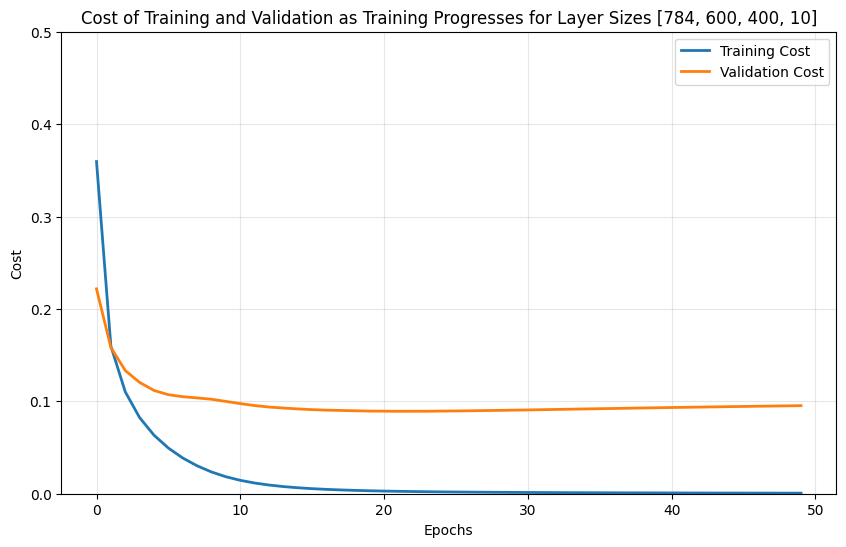

[784, 600, 400, 10]


In [223]:
def plot_training_progress(train_costs, val_costs):
    # making graphs to plot the training and validation costs over epochs
    # changing learning rate and layer sizes should change what the graph looks like

    plt.figure(figsize=(10, 6))
    plt.plot(train_costs, label='Training Cost', linewidth=2) 
    plt.plot(val_costs, label='Validation Cost', linewidth=2)
    plt.xlabel('Epochs') # x axis label
    plt.ylabel('Cost') #y axis label
    plt.title('Cost of Training and Validation as Training Progresses for Layer Sizes [784, 600, 400, 10]') #title
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('linear')
    plt.ylim(0,.5)
    plt.show()

# plot the results
plot_training_progress(train_costs, val_costs)
print(layer_sizes)

In [224]:
# metric for measuring accuracy 

def predict(X, parameters, layer_sizes):
    #p redictions
    Y_hat, _ = forward_propagation(X, parameters, layer_sizes)
    predictions = np.argmax(Y_hat, axis=1)
    return predictions

def calculate_accuracy(Y_true, Y_pred):
    # calculate accuracy: (correct predictions) / (total predictions)
    
    if Y_true.ndim > 1:  # if one-hot encoded, convert to labels
        Y_true = np.argmax(Y_true, axis=1)
    accuracy = np.mean(Y_true == Y_pred)
    return accuracy

# make predictions on validation set
val_predictions = predict(X_val, parameters, layer_sizes)
val_accuracy = calculate_accuracy(Y_val, val_predictions)

print(f"\n\nValidation Accuracy: {val_accuracy:.4f} ({val_accuracy * 100:.2f}%)\n\n")

# check training accuracy
train_predictions = predict(X_train[:1000], parameters, layer_sizes)  # Smaller sample
train_accuracy = calculate_accuracy(Y_train[:1000], train_predictions)
print(f"Training Accuracy (sample): {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")

Layer 1: Z1.shape = (8400, 600), A1.shape = (8400, 600)
Layer 2: Z2.shape = (8400, 400), A2.shape = (8400, 400)
Output Layer 3: Z3.shape = (8400, 10), A3.shape = (8400, 10)


Validation Accuracy: 0.9761 (97.61%)


Layer 1: Z1.shape = (1000, 600), A1.shape = (1000, 600)
Layer 2: Z2.shape = (1000, 400), A2.shape = (1000, 400)
Output Layer 3: Z3.shape = (1000, 10), A3.shape = (1000, 10)
Training Accuracy (sample): 1.0000 (100.00%)


Visualizing predictions on validation set:
Layer 1: Z1.shape = (10, 600), A1.shape = (10, 600)
Layer 2: Z2.shape = (10, 400), A2.shape = (10, 400)
Output Layer 3: Z3.shape = (10, 10), A3.shape = (10, 10)


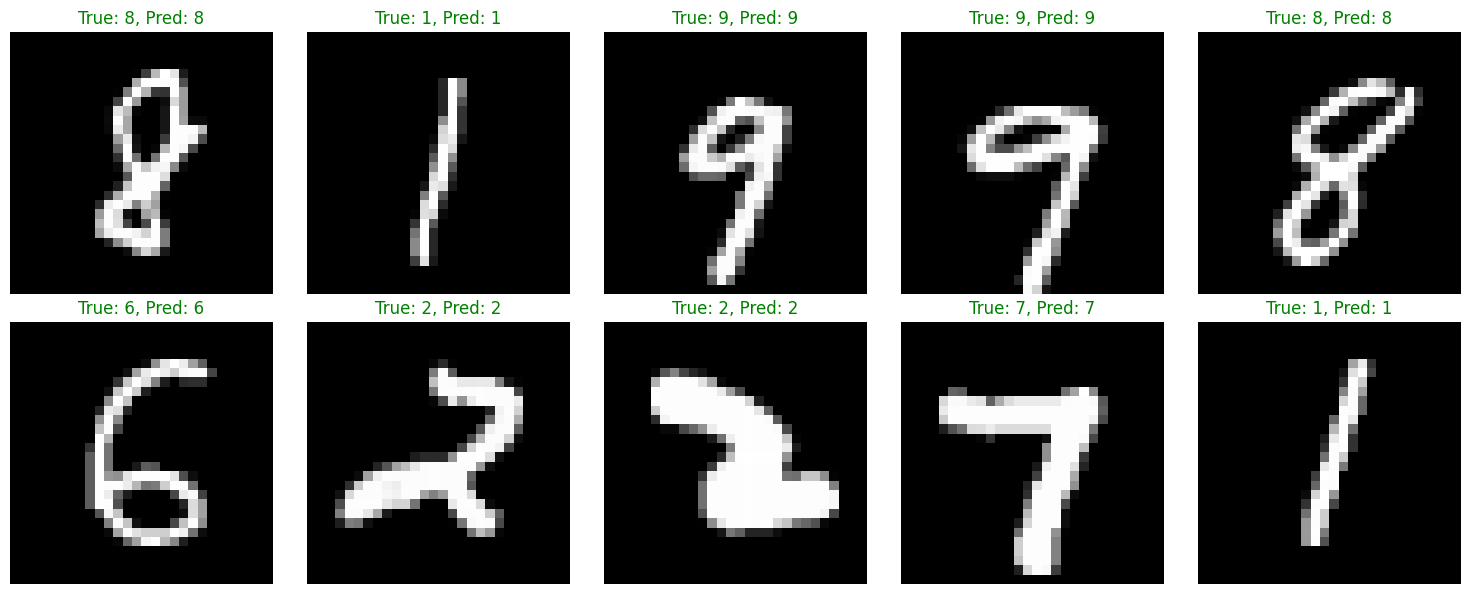

In [225]:
def visualize_predictions(X, Y_true, parameters, layer_sizes, num_examples=10):
    # visualize actual images with their predictions
    
    predictions = predict(X, parameters, layer_sizes)
    
    if Y_true.ndim > 1:  # Convert one-hot back to labels
        Y_true = np.argmax(Y_true, axis=1)
    
    plt.figure(figsize=(15, 6))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        
        # reshape into 28x28 and display
        img = X[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        
        # color code: green if correct, red if wrong
        color = 'green' if predictions[i] == Y_true[i] else 'red'
        plt.title(f'True: {Y_true[i]}, Pred: {predictions[i]}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# visualize some validation examples
print("Visualizing predictions on validation set:")
visualize_predictions(X_val[:10], Y_val[:10], parameters, layer_sizes)

In [226]:
"""
Neural Network from Scratch for MNIST Classification

- Neural network architecture and mathematical implementation guidance 
  from OpenAI's ChatGPT (https://chat.openai.com/)
- MNIST dataset from Yann LeCun et al.
"""

"\nNeural Network from Scratch for MNIST Classification\n\n- Neural network architecture and mathematical implementation guidance \n  from OpenAI's ChatGPT (https://chat.openai.com/)\n- MNIST dataset from Yann LeCun et al.\n"